Simon Capel - 5870674 - Notebook supporting the Final Assignment for Language Technology - MBA BD

Code in this notebook was inspired by:
- Muller & Guido: Introduction to Machine Learning with Python - Chapter 7 (Working with Text Data)
- Lecture Slides
- BERT implementation example (https://colab.research.google.com/github/jalammar/jalammar.github.io/blob/master/notebooks/bert/A_Visual_Notebook_to_Using_BERT_for_the_First_Time.ipynb#scrollTo=JD3fX2yh6PTx)

In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import  LogisticRegression, SGDClassifier
from sklearn.metrics import  confusion_matrix, classification_report, roc_auc_score
from sklearn.decomposition import LatentDirichletAllocation
from stop_words import get_stop_words
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import mglearn
import nltk
nltk.download('punkt')
from nltk import word_tokenize
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import numpy as np
import re
import torch
import transformers as ppb

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\simon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# EDA

In [2]:
df = pd.read_csv("Dutch Sarcasm.csv")
df = df.drop_duplicates(subset = ['headline'])

We import the dataset and remove duplicates in the variable headline.

In [3]:
np.bincount(df.is_sarcastic)

array([8261, 5001], dtype=int64)

Our dataset is reasonably balanced between sarcastic and non sarcastic news headlines

In [4]:
vect = CountVectorizer()
docs = df.headline
vect.fit(docs)
bag_of_words = vect.transform(docs)
repr(bag_of_words)

"<13262x18715 sparse matrix of type '<class 'numpy.int64'>'\n\twith 115621 stored elements in Compressed Sparse Row format>"

We create a dictionary which contains 18715 unique words over the roughly 13,000 documents available

In [5]:
bag_of_words[0]

<1x18715 sparse matrix of type '<class 'numpy.int64'>'
	with 10 stored elements in Compressed Sparse Row format>

first headline apparently has 10 words

In [6]:
for i in bag_of_words[0]:
    print (i)

  (0, 2266)	1
  (0, 4189)	1
  (0, 5269)	1
  (0, 6761)	1
  (0, 9793)	1
  (0, 10127)	1
  (0, 10257)	1
  (0, 11316)	1
  (0, 11400)	1
  (0, 11648)	1


In [7]:
df.headline[0]

'Ook mysterieuze metalen monoliet opgedoken bij het Friese dorpje Oudehorne'

In [8]:
vect.get_feature_names()[10127]

'monoliet'

Inspecting one of the features provided by the sparse matrix

# Baseline Model

In [9]:
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, df.is_sarcastic, 
                                                    random_state=42, train_size=0.70, test_size = 0.30)
#baseline model
logreg = LogisticRegression(max_iter = 1000)
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
grid = GridSearchCV(logreg, param_grid = param_grid,return_train_score = True, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)
print('Best C:', grid.best_estimator_.get_params()['C'])

Best C: 1


In [10]:
roc_auc_score(y_test, grid.predict(X_test))

0.8284508927729697

In [11]:
print(classification_report(y_test, grid.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      2485
           1       0.78      0.79      0.79      1494

    accuracy                           0.84      3979
   macro avg       0.83      0.83      0.83      3979
weighted avg       0.84      0.84      0.84      3979



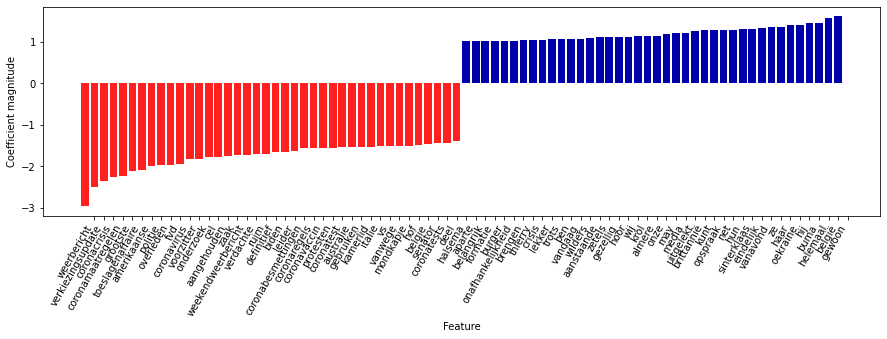

In [12]:
mglearn.tools.visualize_coefficients(grid.best_estimator_.coef_, vect.get_feature_names(), n_top_features=40)

We train a baseline model in with no pre-processing of the data and identify performance of the model and the features

# Excluding Infrequent Words

In [13]:
vect = CountVectorizer(min_df=5)
vect.fit(docs)
bag_of_words = vect.transform(docs)
repr(bag_of_words)

X_train, X_test, y_train, y_test = train_test_split(bag_of_words, df.is_sarcastic, 
                                                    random_state=42, train_size=0.70, test_size = 0.30)


logreg = LogisticRegression(max_iter = 1000)
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
grid = GridSearchCV(logreg, param_grid = param_grid,return_train_score = True, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)
print('Best C:', grid.best_estimator_.get_params()['C'])

Best C: 1


In [14]:
roc_auc_score(y_test, grid.predict(X_test))

0.8202671181035343

In [15]:
print(classification_report(y_test, grid.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      2485
           1       0.76      0.79      0.78      1494

    accuracy                           0.83      3979
   macro avg       0.82      0.82      0.82      3979
weighted avg       0.83      0.83      0.83      3979



we train a model which filters words with a low frequency of occuring

# Excluding Stopwords

In [16]:
stop_words = get_stop_words('nl')
print(stop_words)

['aan', 'al', 'alles', 'als', 'altijd', 'andere', 'ben', 'bij', 'daar', 'dan', 'dat', 'de', 'der', 'deze', 'die', 'dit', 'doch', 'doen', 'door', 'dus', 'een', 'eens', 'en', 'er', 'ge', 'geen', 'geweest', 'haar', 'had', 'heb', 'hebben', 'heeft', 'hem', 'het', 'hier', 'hij', 'hoe', 'hun', 'iemand', 'iets', 'ik', 'in', 'is', 'ja', 'je', 'kan', 'kon', 'kunnen', 'maar', 'me', 'meer', 'men', 'met', 'mij', 'mijn', 'moet', 'na', 'naar', 'niet', 'niets', 'nog', 'nu', 'of', 'om', 'omdat', 'onder', 'ons', 'ook', 'op', 'over', 'reeds', 'te', 'tegen', 'toch', 'toen', 'tot', 'u', 'uit', 'uw', 'van', 'veel', 'voor', 'want', 'waren', 'was', 'wat', 'werd', 'wezen', 'wie', 'wil', 'worden', 'wordt', 'zal', 'ze', 'zelf', 'zich', 'zij', 'zijn', 'zo', 'zonder', 'zou']


In [17]:

vect = CountVectorizer(min_df=5, stop_words=stop_words)
vect.fit(docs)
bag_of_words = vect.transform(docs)
repr(bag_of_words)

X_train, X_test, y_train, y_test = train_test_split(bag_of_words, df.is_sarcastic, 
                                                    random_state=42, train_size=0.70, test_size = 0.30)
logreg = LogisticRegression(max_iter = 1000)
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
grid = GridSearchCV(logreg, param_grid = param_grid,return_train_score = True, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)
print('Best C:', grid.best_estimator_.get_params()['C'])

Best C: 1


In [18]:
roc_auc_score(y_test, grid.predict(X_test))

0.8099519472928602

In [19]:
print(classification_report(y_test, grid.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      2485
           1       0.75      0.77      0.76      1494

    accuracy                           0.82      3979
   macro avg       0.81      0.81      0.81      3979
weighted avg       0.82      0.82      0.82      3979



# Applying tf-idf scaling

In [20]:
X_train, X_test, y_train, y_test = train_test_split(docs, df.is_sarcastic, 
                                                    random_state=42, train_size=0.70, test_size = 0.30)

pipe = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter = 1000))
param_grid = {"logisticregression__C": [ 1, 10, 100], "tfidfvectorizer__min_df": [0,1,2,3,4,5,6,7,8,9,10] }
grid = GridSearchCV(pipe, param_grid = param_grid,return_train_score = True, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)
print('Best C:', grid.best_estimator_.get_params()['logisticregression__C'])
print('Best min_df:', grid.best_estimator_.get_params()['tfidfvectorizer__min_df'])

Best C: 10
Best min_df: 0


In [21]:
roc_auc_score(y_test, grid.predict(X_test))


0.7997590630799521

In [22]:
print(classification_report(y_test, grid.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      2485
           1       0.80      0.71      0.75      1494

    accuracy                           0.82      3979
   macro avg       0.82      0.80      0.81      3979
weighted avg       0.82      0.82      0.82      3979



# Evaluating the impact of including bi/trigrams

In [50]:
X_train, X_test, y_train, y_test = train_test_split(docs, df.is_sarcastic, 
                                                    random_state=42, train_size=0.70, test_size = 0.30)

pipe = make_pipeline(CountVectorizer(), LogisticRegression(max_iter = 10000))
param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'countvectorizer__ngram_range': [(1,1),(1,2),(1,3)] }
grid = GridSearchCV(pipe, param_grid = param_grid,return_train_score = True, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)
print('Best C:', grid.best_estimator_.get_params()['logisticregression__C'])
print('Best N_Grams:', grid.best_estimator_.get_params()['countvectorizer__ngram_range'])


Best C: 1000
Best N_Grams: (1, 2)


In [51]:
roc_auc_score(y_test, grid.predict(X_test))

0.8316500071378741

In [52]:
print(classification_report(y_test, grid.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      2485
           1       0.77      0.81      0.79      1494

    accuracy                           0.84      3979
   macro avg       0.83      0.83      0.83      3979
weighted avg       0.84      0.84      0.84      3979



# Stemming

In [26]:
stemmer = nltk.stem.snowball.DutchStemmer()

test = ['huis', 'huizen', 'gebouw', 'gebouwen', 'worden', 'wordt', 'woorden', 'woord', 'corona', 'coronavirus']

stem_test = [stemmer.stem(w) for w in test]
print(stem_test)

['huis', 'huiz', 'gebouw', 'gebouw', 'word', 'wordt', 'woord', 'woord', 'corona', 'coronavirus']


In [27]:
def lower_letters(docs):
    letters_only = re.sub("[^a-zA-Z]", " ", docs)
    lower_case = letters_only.lower()
    return(lower_case)

def tokenize (docs):
    tokens = word_tokenize(lower_letters(docs))
    words = [w for w in tokens]
    stems = [stemmer.stem(word) for word in words]
    return(stems)


vect = CountVectorizer(tokenizer = tokenize)

vect.fit(docs)
BoW_stemmed = vect.transform(docs)
repr(BoW_stemmed)

C:\Users\simon\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


"<13262x15742 sparse matrix of type '<class 'numpy.int64'>'\n\twith 114942 stored elements in Compressed Sparse Row format>"

stemming worked because matrix is indeed reduced

In [53]:
X_train, X_test, y_train, y_test = train_test_split(docs, df.is_sarcastic, 
                                                    random_state=42, train_size=0.70, test_size = 0.30)

# we use the tokenizer function defined above with the optimal number of ngrams found in the previous step
# we add the tokenizer to the pipeline to avoid information leakage
pipe = make_pipeline(CountVectorizer(tokenizer = tokenize,ngram_range = (1,2) ), LogisticRegression(max_iter = 1000))
param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
grid = GridSearchCV(pipe, param_grid = param_grid,return_train_score = True, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)
print('Best C:', grid.best_estimator_.get_params()['logisticregression__C'])

Best C: 1000


In [54]:
roc_auc_score(y_test, grid.predict(X_test))

0.8315205826660094

In [55]:
print(classification_report(y_test, grid.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      2485
           1       0.78      0.80      0.79      1494

    accuracy                           0.84      3979
   macro avg       0.83      0.83      0.83      3979
weighted avg       0.84      0.84      0.84      3979



# LDA

In [31]:
#excluding very frequent/infrequent words as input for the LDA
vect = CountVectorizer(max_features=10000, max_df=0.15, stop_words=stop_words)
BoW = vect.fit_transform(docs)

lda = LatentDirichletAllocation(n_components=10, learning_method="batch", max_iter=25, random_state=42)
topics = lda.fit_transform(BoW)

topics [0]

array([0.02000099, 0.02000237, 0.81998856, 0.02000113, 0.02      ,
       0.02      , 0.02      , 0.02000694, 0.02      , 0.02      ])

In [32]:
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
feature_names = np.array(vect.get_feature_names())
mglearn.tools.print_topics(topics=range(10), feature_names=feature_names, sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
nederland     trump         weerbericht   kabinet       man           
pvda          biden         af            nederland     jaar          
corona        vvd           dag           kamer         cel           
maakt         president     toe           rutte         verdachte     
tweede        cda           zon           minister      gaat          
vanaf         oud           regen         tweede        aanslag       
mag           stapt         kans          coronamaatregeleneist          
burgemeester  politiek      later         jaar          opgepakt      
wel           verkiezingsupdateneemt         gaat          vrouw         
mondkapje     d66           krijgt        euro          vier          


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------     

In [33]:
X_train, X_test, y_train, y_test = train_test_split(topics, df.is_sarcastic, 
                                                    random_state=42, train_size=0.70, test_size = 0.30)

pipe = make_pipeline( LogisticRegression(max_iter = 1000))
param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid = GridSearchCV(pipe, param_grid = param_grid,return_train_score = True, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)
print('Best C:', grid.best_estimator_.get_params()['logisticregression__C'])
roc_auc_score(y_test, grid.predict(X_test))

Best C: 1000


0.5

In [34]:
print(classification_report(y_test, grid.predict(X_test)))

              precision    recall  f1-score   support

           0       0.62      1.00      0.77      2485
           1       0.00      0.00      0.00      1494

    accuracy                           0.62      3979
   macro avg       0.31      0.50      0.38      3979
weighted avg       0.39      0.62      0.48      3979



C:\Users\simon\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# BERT

In [35]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [36]:
tokenized = docs.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

np.array(padded).shape

(13262, 58)

In [37]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)
    
features = last_hidden_states[0][:,0,:].numpy()

labels = df.is_sarcastic

In [40]:
X_train, X_test, y_train, y_test = train_test_split(features,  labels,
                                                    random_state=42, train_size=0.70, test_size = 0.30)
pipe = make_pipeline( LogisticRegression(max_iter = 10000))
param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid = GridSearchCV(pipe, param_grid = param_grid,return_train_score = True, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)
print('Best C:', grid.best_estimator_.get_params()['logisticregression__C'])
roc_auc_score(y_test, grid.predict(X_test))

Best C: 10


0.8124068372753254

In [41]:
print(classification_report(y_test, grid.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      2485
           1       0.80      0.73      0.77      1494

    accuracy                           0.83      3979
   macro avg       0.82      0.81      0.82      3979
weighted avg       0.83      0.83      0.83      3979

